In [1]:
import sys
if not '..' in sys.path:
    sys.path.append('..')
from analysis import collection, analysis, emg
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import numpy as np
import pickle
from scipy import stats

%matplotlib inline
plt.style.use('ggplot')
mpl.rcParams.update({'axes.labelsize': 16})

image_path = Path("/Users/spencer/phd/phd/images/")

In [2]:
task_name = "center_hold"
with open('olympics_subjects.pkl', 'rb') as handle:
    subjects = pickle.load(handle)

In [3]:
def load_raw_subject_movement_stack(subject):
    # session, trial, channel, time
    stack = np.empty(shape=(2,14,64,2000))
    stack[:] = np.nan
    for session_idx, session_name in enumerate(["session_0", "session_1"]):
        filenames = analysis.get_movement_filenames("emg_olympics", subject.name, session_name)
        for bar_idx, filename in enumerate(filenames):
            e = analysis.load_movement_emg(filename)
            e = emg.filter_emg(e, subject.variance)
            assert e.shape[1] == 64, e.shape
            assert e.shape[0] > e.shape[1], e.shape
            stack[session_idx, bar_idx, :, :e.shape[0]] = e.T
    return np.array(stack)

def compute_cutoffs(subject_stack):
    # global cutoffs
    assert subject_stack.shape[2] == 64, subject_stack.shape
    samples = analysis.remove_nan_rows(subject_stack.transpose(0,1,3,2).reshape(-1,64))
    lognorms = np.log(np.linalg.norm(samples,axis=1))
    return (np.percentile(lognorms,1), np.percentile(lognorms,99.9))

def find_cutoff_mask(signal,cutoffs):
    # use this with single trials!
    assert signal.shape[1] == 64
    assert signal.shape[0] > signal.shape[1], signal.shape
    assert len(cutoffs) == 2
    log_norm = np.log(np.linalg.norm(signal,axis=1))
    mask = (cutoffs[0] < log_norm) * (log_norm < cutoffs[1])
    return np.arange(signal.shape[0])[mask]

def find_within_trial_mask(signal):
    # within trial values -- 30th percentile of log X
    assert signal.shape[1] == 64
    assert signal.shape[0] > signal.shape[1], signal.shape
    log_norm = np.log(np.linalg.norm(signal,axis=1))
    mean_log_norm = np.mean(log_norm)
    std_log_norm = np.std(log_norm)
    # assuming large samples and rv being lognormal, this is roughly the 30th percentile
    mask = log_norm > (mean_log_norm - 0.5*std_log_norm)
    return np.arange(signal.shape[0])[mask]

def find_trial_filter_indices(signal, cutoffs):
    # combine filters
    assert signal.shape[1] == 64, signal.shape
    assert signal.shape[0] > signal.shape[1], signal.shape
    return np.array([i for i in range(signal.shape[0]) if ((i in find_within_trial_mask(signal)) and (i in find_cutoff_mask(signal, cutoffs)))])

# load and filter the data
def filter_subject_movement_stack(subject_stack):
    assert subject_stack.shape[2] == 64
    assert len(subject_stack.shape) == 4
    # session, trial, channel, time
    stack = np.zeros_like(subject_stack)
    stack[:] = np.nan
    cutoffs = compute_cutoffs(subject_stack)
    for session_idx, session_trials in enumerate(subject_stack):
        for trial_idx, e in enumerate(session_trials):
            assert e.shape[0] == 64, e.shape
            assert e.shape[1] > e.shape[0], e.shape
            e_without_nans = analysis.remove_nan_rows(e.T)
            if e_without_nans.shape[0] < e_without_nans.shape[1]:
                print(f"Empty trial: {session_idx,trial_idx}")
            else:
                indices = find_trial_filter_indices(e_without_nans,cutoffs)
                e = e[:,indices]
                # stuff this into stack array
                stack[session_idx, trial_idx, :, :e.shape[1]] = e
    return stack

## build data brick, then load it

In [27]:
subject_movement_stacks = []
subject_raw_movement_stacks = []
for subject_idx, subject in enumerate(subjects[:1]):
    print("Loading subject ", subject_idx)
    raw_stack = load_raw_subject_movement_stack(subject)
    cutoffs = compute_cutoffs(raw_stack)
    subject_raw_movement_stacks += [raw_stack]
    subject_movement_stacks += [filter_subject_movement_stack(raw_stack)]
subject_raw_movement_stacks = np.array(subject_raw_movement_stacks)
subject_movement_stacks = np.array(subject_movement_stacks)
print(subject_raw_movement_stacks.shape,subject_movement_stacks.shape)

Loading subject  0
(1, 2, 14, 64, 2000) (1, 2, 14, 64, 2000)


## save it to disk!

In [28]:
np.save("subject_movement_stacks.npy", subject_movement_stacks)
np.save("subject_raw_movement_stacks.npy", subject_raw_movement_stacks)

## test loading

In [29]:
subject_movement_stacks = np.load("subject_movement_stacks.npy")
subject_raw_movement_stacks = np.load("subject_raw_movement_stacks.npy")
subject_movement_stacks.shape, subject_raw_movement_stacks.shape

((1, 2, 14, 64, 2000), (1, 2, 14, 64, 2000))

## inspect natural data for a test subject

In [31]:
# test stepping through raw data
subject_idx = 0
subject = subjects[subject_idx]
session_idx = 1
trial_idx = 11
e = analysis.remove_nan_rows(subject_raw_movement_stacks[subject_idx,session_idx,trial_idx,:,:].T)
indices = find_trial_filter_indices(e,cutoffs)

## inspect EMG signal

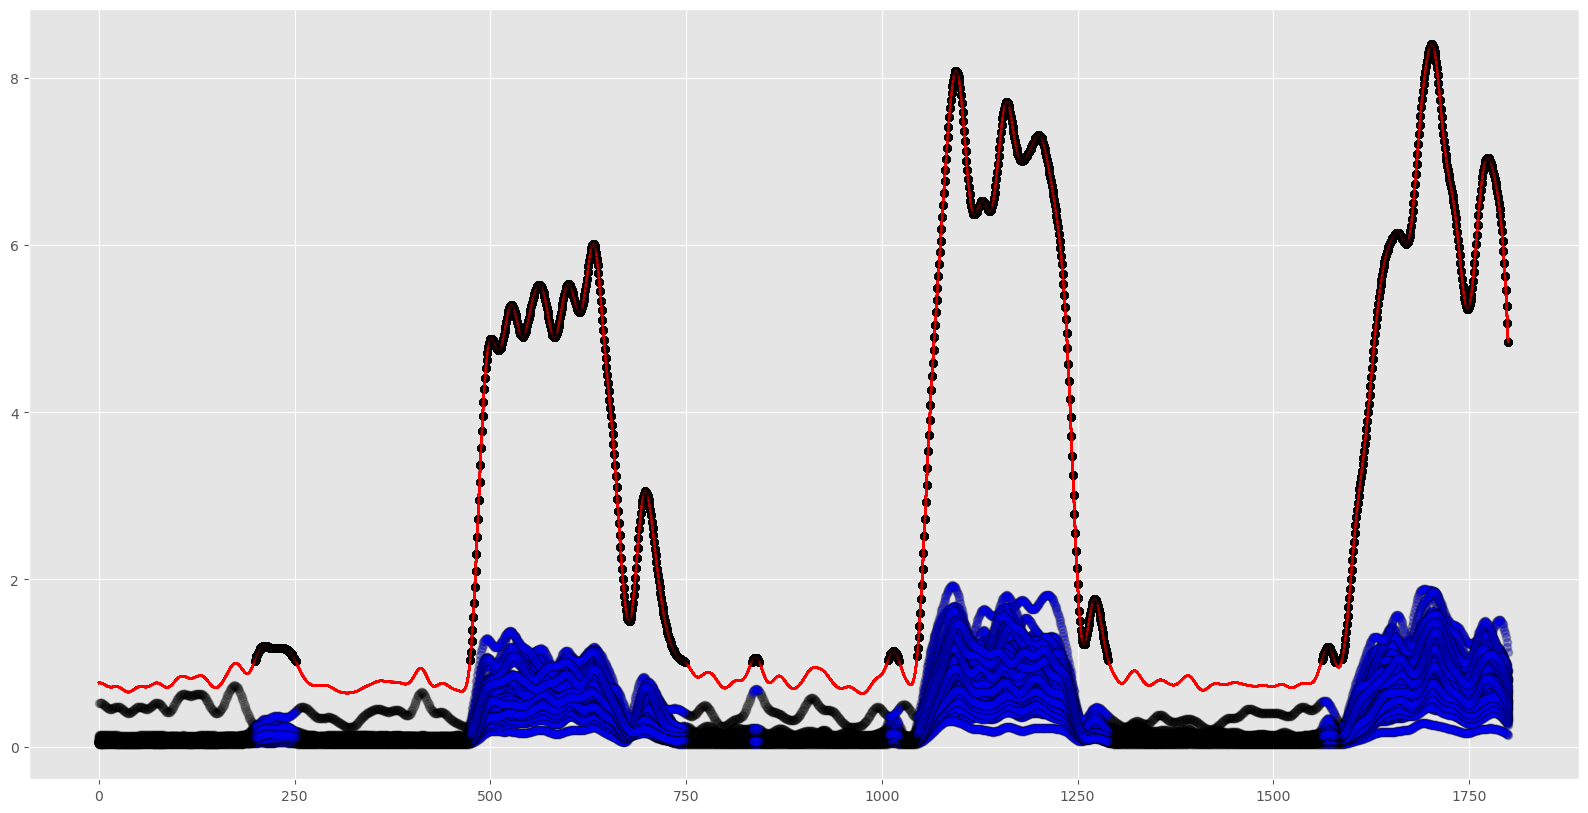

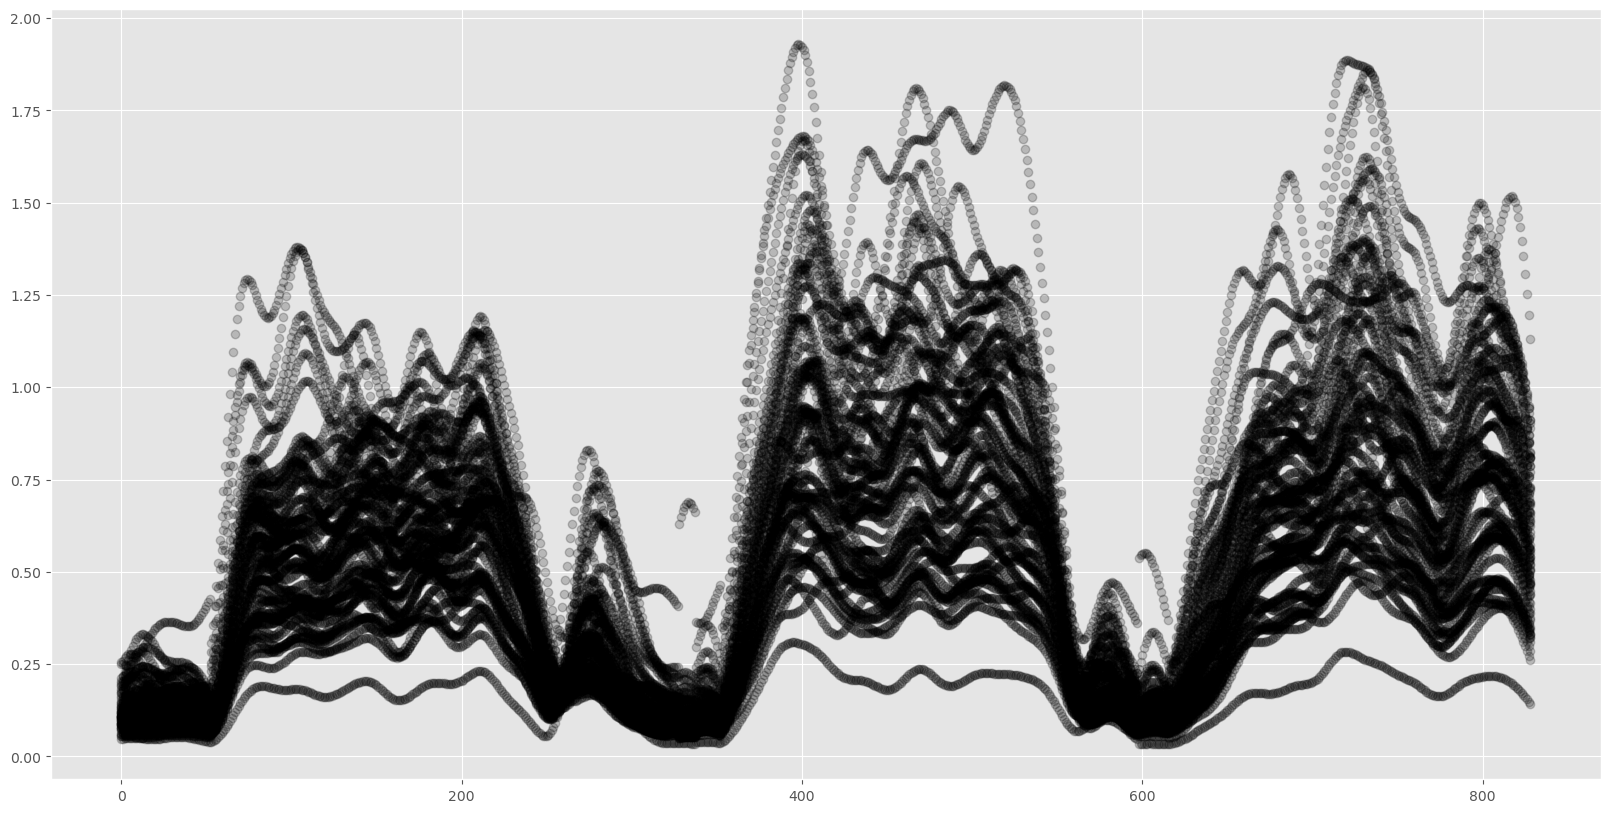

In [32]:
plt.figure(figsize=(20,10))
for ch in range(64):
    plt.plot(e[:,ch],'ko',alpha=0.2)
    plt.plot(indices, e[indices,ch],'bo',alpha=0.2,markersize=5)
    plt.plot(np.linalg.norm(e,axis=1),"r",)
    plt.plot(indices,np.linalg.norm(e,axis=1)[indices],"ko",alpha=0.2,markersize=5)
plt.figure(figsize=(20,10))
for ch in range(64):    
    plt.plot(subject_movement_stacks[subject_idx,session_idx,trial_idx,ch],'ko',alpha=0.2)

(829,)


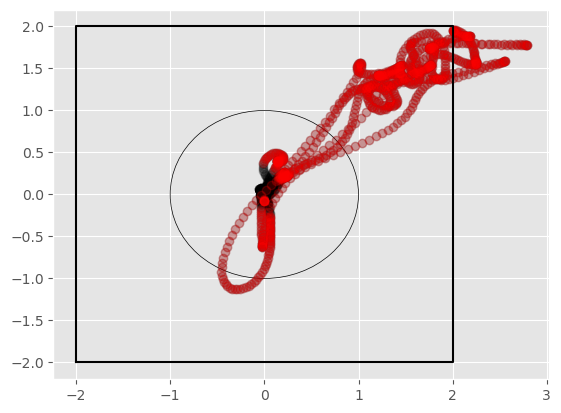

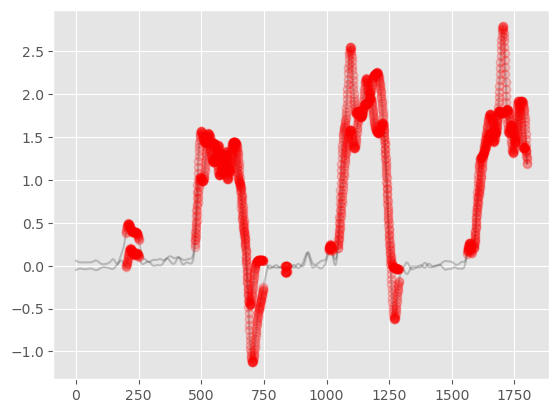

In [33]:
d = subject.decoder[-2:,:]
t = d @ e.T
print(indices.shape)
plt.figure()
plt.plot(t[0],t[1],"ko",alpha=0.2)
plt.plot(t[0,indices],t[1,indices],"ro",alpha=0.2)
l = 2
plt.plot([-l,-l,l,l,-l],[-l,l,l,-l,-l],'k')
c = plt.Circle([0,0],1,color="k",fill=None)
plt.gca().add_patch(c)

plt.figure()
plt.plot(t[0],'k',alpha=0.2)
plt.plot(t[1],'k',alpha=0.2)
plt.plot(indices,t[0,indices],'ro',alpha=0.2)
plt.plot(indices,t[1,indices],'ro',alpha=0.2)

NormaltestResult(statistic=288930.8459842291, pvalue=0.0)


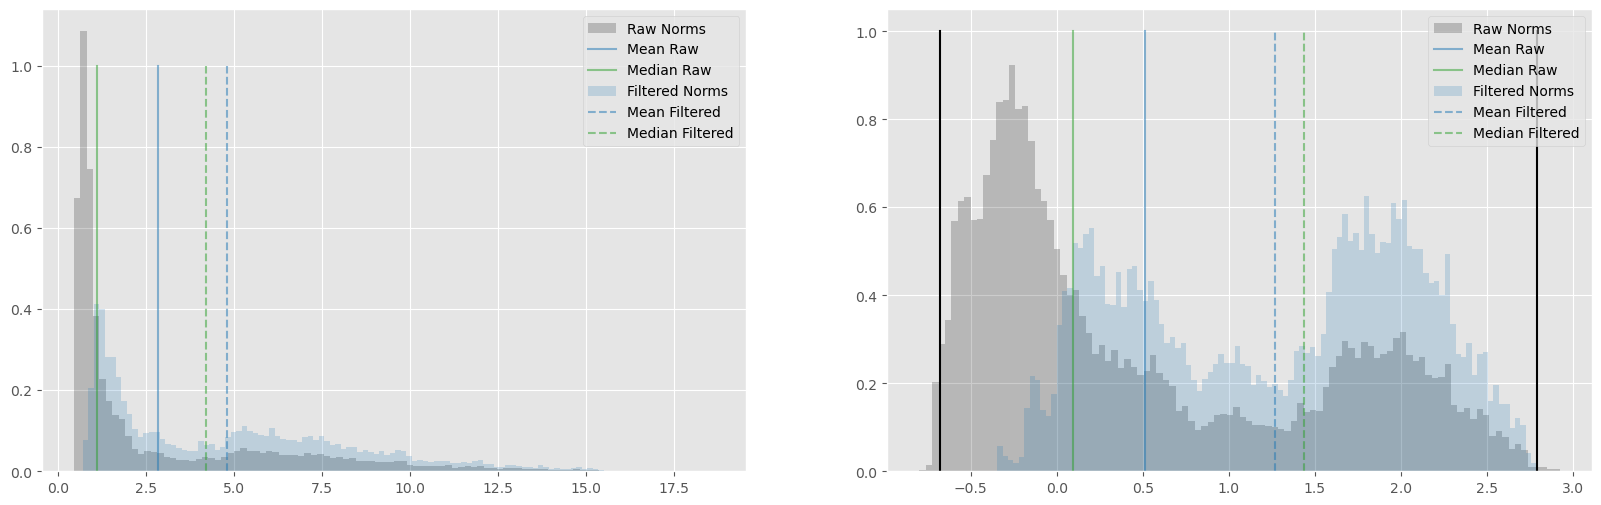

In [36]:
for subject_idx, subject in enumerate(subjects[:1]):
    fig, axes = plt.subplots(1,2,figsize=(20,6))

    raw_samples = analysis.remove_nan_rows(subject_raw_movement_stacks[subject_idx].transpose(0,1,3,2).reshape(-1,64))
    filtered_samples = analysis.remove_nan_rows(subject_movement_stacks[subject_idx].transpose(0,1,3,2).reshape(-1,64))

    raw_norms = np.linalg.norm(raw_samples,axis=1)
    filtered_norms = np.linalg.norm(filtered_samples,axis=1)
    raw_log_norms = np.log(np.linalg.norm(raw_samples,axis=1))
    filtered_log_norms = np.log(np.linalg.norm(filtered_samples,axis=1))

    def plot_stats(signal, ax, linestyle="-", label=""):
        mean = np.mean(signal)
        ax.plot([mean, mean], [0,1],'tab:blue',linestyle=linestyle,label="Mean" + label,alpha=0.5)
        median = np.median(signal)
        ax.plot([median, median], [0,1],'tab:green',linestyle=linestyle,label="Median" + label,alpha=0.5)

    # sample norms
    axes[0].hist(raw_norms,color="k",density=True,alpha=0.2,bins=100,label="Raw Norms")
    plot_stats(raw_norms, axes[0],label=" Raw")
    # filtered norms
    axes[0].hist(filtered_norms,color="tab:blue",density=True,alpha=0.2,bins=100,label="Filtered Norms")
    plot_stats(filtered_norms,axes[0],linestyle="--",label=" Filtered")
    axes[0].legend()

    # sample norms
    axes[1].hist(raw_log_norms,color="k",density=True,alpha=0.2,bins=100,label="Raw Norms")
    plot_stats(raw_log_norms, axes[1],label=" Raw")
    # filtered norms
    axes[1].hist(filtered_log_norms,color="tab:blue",density=True,alpha=0.2,bins=100,label="Filtered Norms")
    plot_stats(filtered_log_norms,axes[1],linestyle="--",label=" Filtered")

    axes[1].plot([cutoffs[0],cutoffs[0]],[0,1],"k")
    axes[1].plot([cutoffs[1],cutoffs[1]],[0,1],"k")

    axes[1].legend()
    print(stats.normaltest(filtered_log_norms))
